## Lab results experiment v4

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-05-31 12:18:28.085505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Why it is important to load dataframe instead of get_best_results

In [3]:
# Load best results
#exp_path = 'hypersearch_31may/pg_solver/0050/0075/rand_n=0050_k=03_m=0075_i=01/baseline'
exp_path = 'hypersearch10/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=01/arch'
print(f"\nLoading experiment results from: {exp_path}.")

restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver)

results = restored_tuner.get_results()

# Check if there have been errors
if results.errors:
    print("Errors reported.")
else:
    print("No errors reported.")

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch10/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=01/arch.
No errors reported.


In [117]:
metrics = ['num_sat', 'num_sat_greedy_1', 
           'num_sat_sample_1_1', 'num_sat_sample_1_2',
           'num_sat_sample_32_1', 'num_sat_sample_32_2',
           'num_sat_sample_64_1', 'num_sat_sample_64_2']

for metric in metrics:
    print(f"{metric}: {results.get_best_result(metric=metric, mode='max', scope='last').metrics[f'{metric}']}")

num_sat: 76.15625
num_sat_greedy_1: 79.0
num_sat_sample_1_1: 77.0
num_sat_sample_1_2: 76.0
num_sat_sample_32_1: 80.0
num_sat_sample_32_2: 78.0
num_sat_sample_64_1: 79.0
num_sat_sample_64_2: 79.0


In [118]:
for metric in metrics:
    print(f"{metric}: {results.get_best_result(metric=metric, mode='max', scope='all').metrics[f'{metric}']}")

num_sat: 75.9375
num_sat_greedy_1: 79.0
num_sat_sample_1_1: 73.0
num_sat_sample_1_2: 70.0
num_sat_sample_32_1: 80.0
num_sat_sample_32_2: 78.0
num_sat_sample_64_1: 79.0
num_sat_sample_64_2: 78.0


In [119]:
for metric in metrics:
    print(f"{metric}: {results.get_dataframe(filter_metric=metric, filter_mode='max')[f'{metric}'].max()}")

num_sat: 76.78125
num_sat_greedy_1: 79.0
num_sat_sample_1_1: 79.0
num_sat_sample_1_2: 78.0
num_sat_sample_32_1: 80.0
num_sat_sample_32_2: 79.0
num_sat_sample_64_1: 80.0
num_sat_sample_64_2: 80.0


### Searching for errors

In [5]:
def raytune2best_df(num_vars, exp_folder):
    # get the path for every instance
    exp_path = os.path.join(exp_folder, f'{num_vars:04d}')
    num_clauses = [f for f in os.listdir(exp_path)]
    num_clauses = sorted(num_clauses)
    paths = []
    for num_clause in num_clauses:
        num_clause_path = os.path.join(exp_path, num_clause)
        paths += [os.path.join(num_clause_path, f) for f in os.listdir(num_clause_path)]
    paths = sorted(paths)

    dic_results = {}

    metrics = ['num_sat', 'num_sat_greedy_1', 
            'num_sat_sample_1_1', 'num_sat_sample_1_2',
            'num_sat_sample_32_1', 'num_sat_sample_32_2',
            'num_sat_sample_64_1', 'num_sat_sample_64_2']

    for inst_path in paths:

        restored_tuner = tune.Tuner.restore(path=inst_path, trainable=pg_solver)
        results = restored_tuner.get_results()

        split_path = inst_path.split("/")
        n = split_path[2]
        m = split_path[3]
        i = split_path[4][-2:]
        exp_id = f'{n}/{m}/{i}'
        
        values = [results.get_dataframe(filter_metric=metric, filter_mode="max")[f"{metric}"].max() for metric in metrics]
        dic_results[f'{exp_id}'] = [int(n), int(m), int(i)] + values

    columns = ['n', 'm', 'i', 'mean', 'greedy', 's_1_1', 's_1_2', 's_32_1', 's_32_2', 's_64_1', 's_64_2']

    df_best_pg = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
    df_best_pg.insert(2, 'r', df_best_pg["m"] / df_best_pg["n"])

    # change from num sat clauses to fraction of sat clauses
    for metric in columns[3:]:
        df_best_pg[f'{metric}'] = df_best_pg[f'{metric}'] / df_best_pg['m']

    df_best_pg = pd.melt(df_best_pg, id_vars='r', value_vars=['mean', 'greedy', 's_1_1', 's_1_2', 's_32_1', 's_32_2', 's_64_1', 's_64_2'])
    df_best_pg = df_best_pg.rename(columns={"variable": "search", "value": "frac_sat"})
    
    return df_best_pg

    # plt.figure(figsize = (10,6))
    # sns.set_theme(style="whitegrid", palette="bright")
    # color_pallete = sns.color_palette("bright")

    # sns.lineplot(data=df_plot, x="r", y="frac_sat", hue="search", errorbar=None, palette=color_pallete, marker='o')
    # plt.tight_layout()
    # plt.show()

### 2. Step by step

In [ ]:
num_vars = 20
exp_folder = 'hypersearch/pg_solver'

# get the path for every instance
exp_path = os.path.join('hypersearch/pg_solver', f'{num_vars:04d}')
num_clauses = [f for f in os.listdir(exp_path)]
num_clauses = sorted(num_clauses)
paths = []
for num_clause in num_clauses:
    num_clause_path = os.path.join(exp_path, num_clause)
    paths += [os.path.join(num_clause_path, f) for f in os.listdir(num_clause_path)]
paths = sorted(paths)

dic_results = {}

metrics = ['num_sat', 'num_sat_greedy_1', 
           'num_sat_sample_1_1', 'num_sat_sample_1_2',
           'num_sat_sample_32_1', 'num_sat_sample_32_2',
           'num_sat_sample_64_1', 'num_sat_sample_64_2']

for inst_path in paths:

    restored_tuner = tune.Tuner.restore(path=inst_path, trainable=pg_solver)
    results = restored_tuner.get_results()

    split_path = inst_path.split("/")
    n = split_path[2]
    m = split_path[3]
    i = split_path[4][-2:]
    exp_id = f'{n}/{m}/{i}'
    
    values = [results.get_dataframe(filter_metric=metric, filter_mode="max")[f"{metric}"].max() for metric in metrics]
    dic_results[f'{exp_id}'] = [int(n), int(m), int(i)] + values

columns = ['n', 'm', 'i', 'mean', 'greedy', 's_1_1', 's_1_2', 's_32_1', 's_32_2', 's_64_1', 's_64_2']

best_df = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
best_df.insert(2, 'r', best_df["m"] / best_df["n"])

# change from num sat clauses to fraction of sat clauses
for metric in columns[3:]:
    best_df[f'{metric}'] = best_df[f'{metric}'] / best_df['m']

In [ ]:
best_df

In [ ]:
df_plot = pd.melt(best_df, id_vars='r', value_vars=['mean', 'greedy', 's_1_1', 's_1_2', 's_32_1', 's_32_2', 's_64_1', 's_64_2'])
df_plot = df_plot.rename(columns={"variable": "search", "value": "frac_sat"})
df_plot

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df_plot, x="r", y="frac_sat", hue="search", errorbar=None, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

### WalkSAT

In [6]:
from walksat.walksat_emreyolcu import WalkSATme
import src.utils as utils
import pandas as pd
import os

def paths_for_instances(num_vars=20, data_path='data/rand'):
    '''
    Returs the path for every instance with num_vars variables in the data_path.
    '''
    
    data_path = os.path.abspath(os.path.join(data_path, str(f'{num_vars:04d}')))
    paths = []
    for root, dirs, files in os.walk(data_path):
        for filename in files:
            paths.append(os.path.join(root, filename))
    paths = sorted(paths)
    return paths


def walksat2df(num_vars, data_path, num_tries=[1], num_flips=10000, p=0.5):
    paths = paths_for_instances(num_vars, data_path)

    dic_results = {}
    for i, instance_dir in enumerate(paths):
        # Get instance's filename
        tail = os.path.split(instance_dir)[1]
        instance_filename = os.path.splitext(tail)[0]
        
        # Load instance
        n, m, formula = utils.dimacs2list(instance_dir)
        r = m / float(n)
        exp_id = f'{n:04d}/{m:04d}/{instance_filename[-2:]}'

        for n_tries in num_tries:
            walksat = WalkSATme(max_tries=n_tries, max_flips=num_flips, p=p)
            total_solved = walksat.run(formula, n, m)
            unsats_per_trial = walksat.unsat_clauses

            num_sat_list = []
            for j, trial in enumerate(unsats_per_trial):
                unsat = trial[-1]
                num_sat = m - unsat
                #print(f'{j}: {m} - {unsat} = {num_sat}')
                num_sat_list.append(num_sat)
            #num_sat_list = [(m - trial[-1]) for trial in unsats_per_trial]
            max_num_sat = max(num_sat_list)
            frac_sat = max_num_sat / float(m)
            dic_results[f'{exp_id}-{j}'] = [r, f'walksat_{n_tries}', frac_sat]

    columns = ['r', 'search', 'frac_sat']
    df_best_walksat = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
    return df_best_walksat

def pg_vs_walksat(df_pg, df_walksat):
    df_plot = pd.concat([df_pg, df_walksat], ignore_index=True)
    
    plt.figure(figsize = (10,6))
    sns.set_theme(style="whitegrid", palette="bright")
    color_pallete = sns.color_palette("bright")

    sns.lineplot(data=df_plot, x="r", y="frac_sat", hue="search", errorbar=None, palette=color_pallete, marker='o')
    plt.tight_layout()
    plt.show()

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

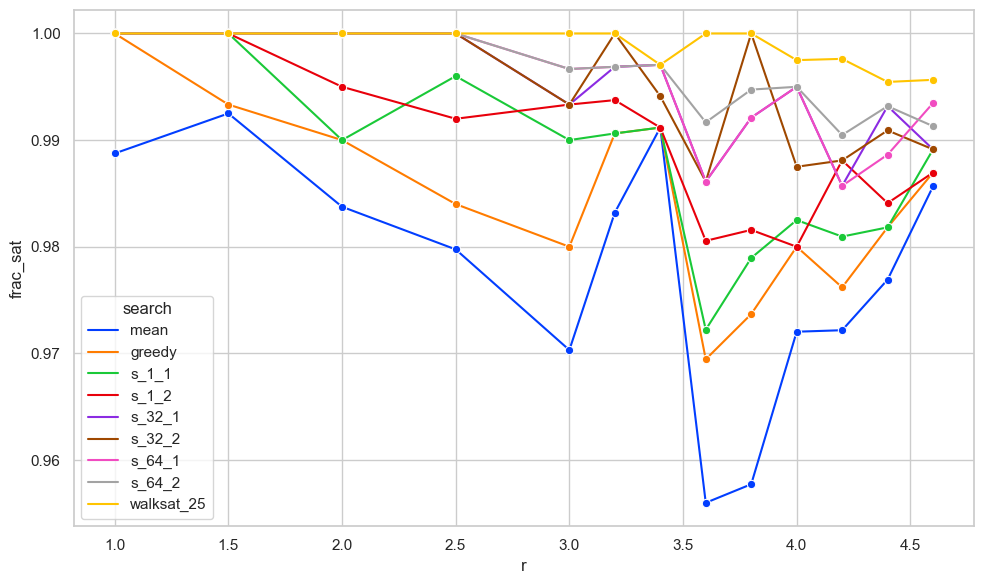

In [7]:
num_vars = 20
exp_folder = 'hypersearch/pg_solver'

data_path = 'data/rand'
num_tries = [25]
num_flips = 750#10000
p = 0.5

df_best_pg = raytune2best_df(num_vars, exp_folder)
df_best_walksat = walksat2df(num_vars, data_path, num_tries, num_flips, p)
pg_vs_walksat(df_best_pg, df_best_walksat)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

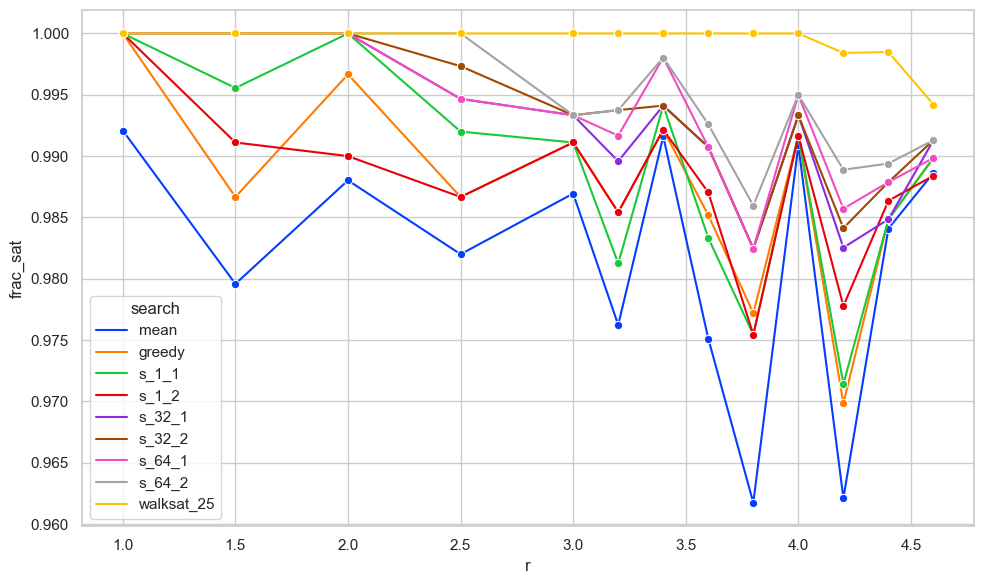

In [8]:
num_vars = 30
exp_folder = 'hypersearch/pg_solver'

data_path = 'data/rand'
num_tries = [25]
num_flips = 750#10000
p = 0.5

df_best_pg = raytune2best_df(num_vars, exp_folder)
df_best_walksat = walksat2df(num_vars, data_path, num_tries, num_flips, p)
pg_vs_walksat(df_best_pg, df_best_walksat)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

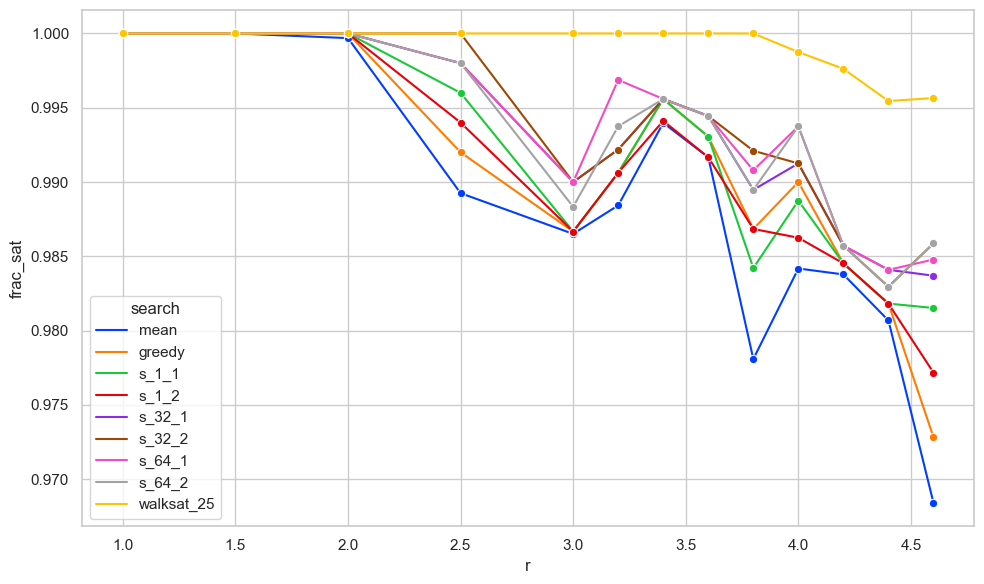

In [9]:
num_vars = 40
exp_folder = 'hypersearch/pg_solver'

data_path = 'data/rand'
num_tries = [25]
num_flips = 750
p = 0.5

df_best_pg = raytune2best_df(num_vars, exp_folder)
df_best_walksat = walksat2df(num_vars, data_path, num_tries, num_flips, p)
pg_vs_walksat(df_best_pg, df_best_walksat)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

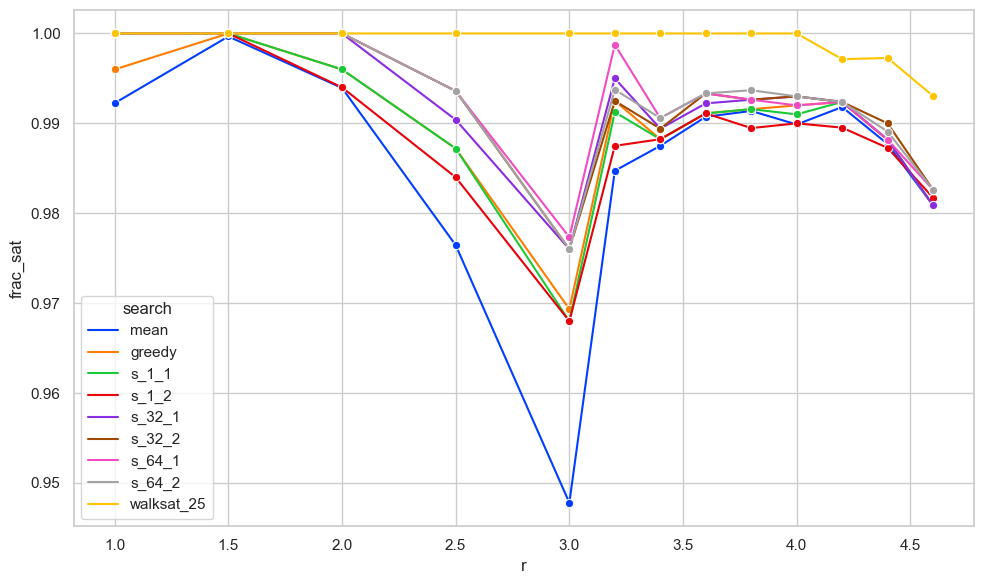

In [10]:
num_vars = 50
exp_folder = 'hypersearch/pg_solver'

data_path = 'data/rand'
num_tries = [25]
num_flips = 750
p = 0.5

df_best_pg = raytune2best_df(num_vars, exp_folder)
df_best_walksat = walksat2df(num_vars, data_path, num_tries, num_flips, p)
pg_vs_walksat(df_best_pg, df_best_walksat)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

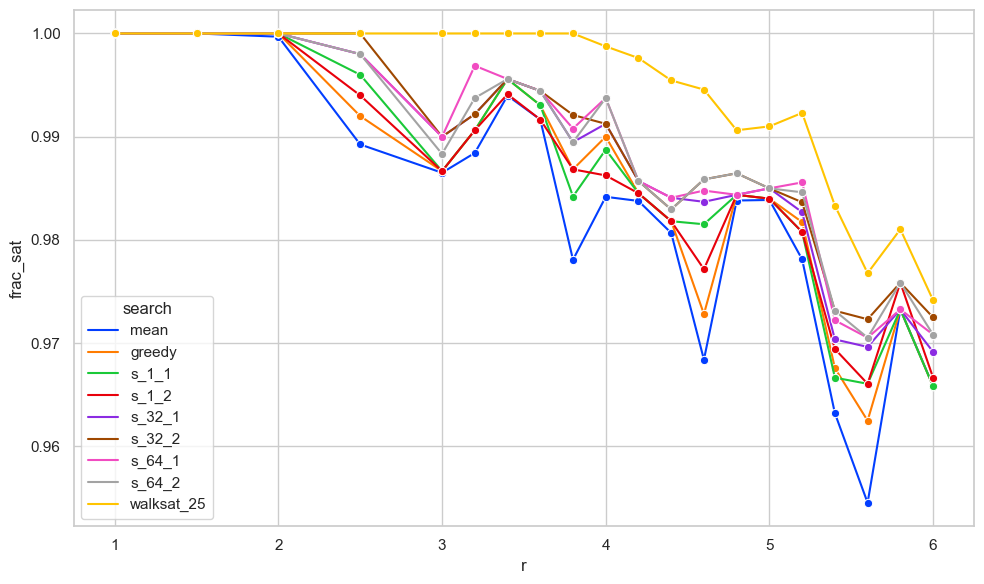

In [121]:
num_vars = 40
exp_folder = 'hypersearch/pg_solver'

data_path = 'data/rand'
num_tries = [25]
num_flips = 750#10000
p = 0.5

df_best_pg = raytune2best_df(num_vars, exp_folder)
df_best_walksat = walksat2df(num_vars, data_path, num_tries, num_flips, p)
pg_vs_walksat(df_best_pg, df_best_walksat)

### Understanding n=50, r=3.0

In [15]:
# Load best results
metrics = ['num_sat', 'num_sat_greedy_1', 
           'num_sat_sample_1_1', 'num_sat_sample_1_2',
           'num_sat_sample_32_1', 'num_sat_sample_32_2',
           'num_sat_sample_64_1', 'num_sat_sample_64_2']

for i in range(5):
    exp_path = f'hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=0{i+1}'
    print(f"\nLoading experiment results from: {exp_path}.")

    restored_tuner = tune.Tuner.restore(path=exp_path,
                                        trainable=pg_solver)

    results = restored_tuner.get_results()

    # Check if there have been errors
    if results.errors:
        print(f"Instance {i+1}: Errors reported.")
    else:
        print(f"Instance {i+1}: No errors reported.")
    
    for metric in metrics:
        print(f"{metric}: {results.get_dataframe(filter_metric=metric, filter_mode='max')[f'{metric}'].max()}")

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=01.
Instance 1: No errors reported.
num_sat: 135.125
num_sat_greedy_1: 143.0
num_sat_sample_1_1: 142.0
num_sat_sample_1_2: 143.0
num_sat_sample_32_1: 145.0
num_sat_sample_32_2: 145.0
num_sat_sample_64_1: 145.0


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


num_sat_sample_64_2: 144.0

Loading experiment results from: hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=02.
Instance 2: No errors reported.
num_sat: 149.78125
num_sat_greedy_1: 150.0
num_sat_sample_1_1: 150.0


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


num_sat_sample_1_2: 150.0
num_sat_sample_32_1: 150.0
num_sat_sample_32_2: 150.0
num_sat_sample_64_1: 150.0
num_sat_sample_64_2: 150.0

Loading experiment results from: hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Instance 3: No errors reported.
num_sat: 137.34375
num_sat_greedy_1: 145.0
num_sat_sample_1_1: 142.0
num_sat_sample_1_2: 143.0
num_sat_sample_32_1: 145.0
num_sat_sample_32_2: 145.0
num_sat_sample_64_1: 146.0
num_sat_sample_64_2: 146.0

Loading experiment results from: hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Instance 4: No errors reported.
num_sat: 140.59375
num_sat_greedy_1: 141.0
num_sat_sample_1_1: 144.0
num_sat_sample_1_2: 142.0
num_sat_sample_32_1: 144.0
num_sat_sample_32_2: 144.0
num_sat_sample_64_1: 144.0
num_sat_sample_64_2: 144.0

Loading experiment results from: hypersearch/pg_solver/0050/0150/rand_n=0050_k=03_m=0150_i=05.
Instance 5: No errors reported.
num_sat: 148.0
num_sat_greedy_1: 148.0
num_sat_sample_1_1: 148.0
num_sat_sample_1_2: 148.0
num_sat_sample_32_1: 148.0
num_sat_sample_32_2: 148.0
num_sat_sample_64_1: 148.0
num_sat_sample_64_2: 148.0


### Hyperparams

In [122]:
num_vars = 20
exp_folder = 'hypersearch/pg_solver'

# get the path for every instance
exp_path = os.path.join(exp_folder, f'{num_vars:04d}')
num_clauses = [f for f in os.listdir(exp_path)]
num_clauses = sorted(num_clauses)
paths = []
for num_clause in num_clauses:
    num_clause_path = os.path.join(exp_path, num_clause)
    paths += [os.path.join(num_clause_path, f) for f in os.listdir(num_clause_path)]
paths = sorted(paths)

config = ['config/decoder', 'config/baseline', 'config/dec_var_initializer', 'config/dec_context_initializer', 'config/entropy_estimator']
df_list = []
for i, instance_dir in enumerate(paths):
    print(f"\nLoading experiment results from: {instance_dir}.")

    restored_tuner = tune.Tuner.restore(path=instance_dir,
                                        trainable=pg_solver)

    results = restored_tuner.get_results()

    df_i = results.get_dataframe(filter_metric="num_sat", filter_mode='max')[['num_sat'] + config]
    df_i = df_i.sort_values(by=['num_sat'], ascending=False).head(1)

    split_path = instance_dir.split("/")
    m = int(split_path[3])
    df_i['num_sat'] = df_i['num_sat'] / m
    df_list.append(df_i)

df_config = pd.concat(df_list, ignore_index=True)
df_config

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0020/rand_n=0020_k=03_m=0020_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0040/rand_n=0020_k=03_m=0040_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0040/rand_n=0020_k=03_m=0040_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0040/rand_n=0020_k=03_m=0040_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0040/rand_n=0020_k=03_m=0040_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0040/rand_n=0020_k=03_m=0040_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0050/rand_n=0020_k=03_m=0050_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0050/rand_n=0020_k=03_m=0050_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0050/rand_n=0020_k=03_m=0050_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0050/rand_n=0020_k=03_m=0050_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0050/rand_n=0020_k=03_m=0050_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0064/rand_n=0020_k=03_m=0064_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0064/rand_n=0020_k=03_m=0064_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0064/rand_n=0020_k=03_m=0064_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0064/rand_n=0020_k=03_m=0064_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0064/rand_n=0020_k=03_m=0064_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0068/rand_n=0020_k=03_m=0068_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0068/rand_n=0020_k=03_m=0068_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0068/rand_n=0020_k=03_m=0068_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0068/rand_n=0020_k=03_m=0068_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0068/rand_n=0020_k=03_m=0068_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0072/rand_n=0020_k=03_m=0072_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0072/rand_n=0020_k=03_m=0072_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0072/rand_n=0020_k=03_m=0072_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0072/rand_n=0020_k=03_m=0072_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0072/rand_n=0020_k=03_m=0072_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0076/rand_n=0020_k=03_m=0076_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0076/rand_n=0020_k=03_m=0076_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0076/rand_n=0020_k=03_m=0076_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0076/rand_n=0020_k=03_m=0076_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0076/rand_n=0020_k=03_m=0076_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0080/rand_n=0020_k=03_m=0080_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0080/rand_n=0020_k=03_m=0080_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0080/rand_n=0020_k=03_m=0080_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0080/rand_n=0020_k=03_m=0080_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0080/rand_n=0020_k=03_m=0080_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0084/rand_n=0020_k=03_m=0084_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0084/rand_n=0020_k=03_m=0084_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0084/rand_n=0020_k=03_m=0084_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0084/rand_n=0020_k=03_m=0084_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0084/rand_n=0020_k=03_m=0084_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0088/rand_n=0020_k=03_m=0088_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0088/rand_n=0020_k=03_m=0088_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0088/rand_n=0020_k=03_m=0088_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0088/rand_n=0020_k=03_m=0088_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0088/rand_n=0020_k=03_m=0088_i=05.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0092/rand_n=0020_k=03_m=0092_i=01.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0092/rand_n=0020_k=03_m=0092_i=02.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0092/rand_n=0020_k=03_m=0092_i=03.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0092/rand_n=0020_k=03_m=0092_i=04.


The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0092/rand_n=0020_k=03_m=0092_i=05.


,num_sat,config/decoder,config/baseline,config/dec_var_initializer,config/dec_context_initializer,config/entropy_estimator
0,1.000000,Transformer,sample,BasicVar,EmptyContext,smooth
1,1.000000,Transformer,ema,Node2VecVar,Node2VecContext,crude
2,0.945312,Transformer,sample,Node2VecVar,EmptyContext,crude
3,1.000000,Transformer,greedy,Node2VecVar,Node2VecContext,crude
4,0.998437,Transformer,sample,Node2VecVar,Node2VecContext,smooth
...,...,...,...,...,...,...
60,0.989130,LSTM,ema,Node2VecVar,EmptyContext,crude
61,0.984375,Transformer,greedy,BasicVar,EmptyContext,smooth
62,0.987432,Transformer,ema,Node2VecVar,EmptyContext,crude
63,0.978261,Transformer,greedy,Node2VecVar,Node2VecContext,smooth


In [91]:
df_config['config/baseline'].nunique()

3

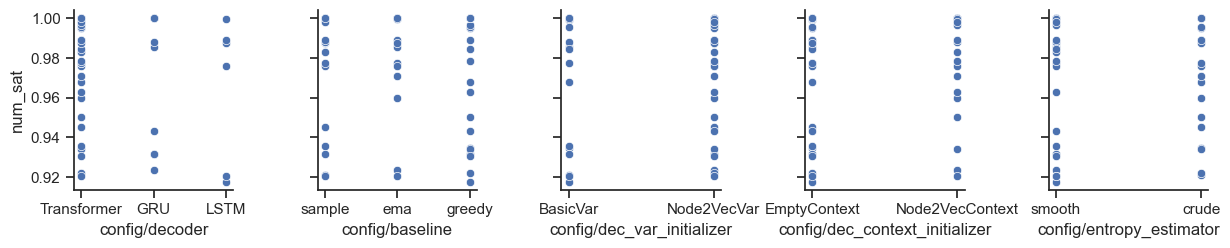

In [123]:
sns.set_theme(style="ticks")
sns.pairplot(df_config, y_vars='num_sat', x_vars=config)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.



Loading experiment results from: hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=05.


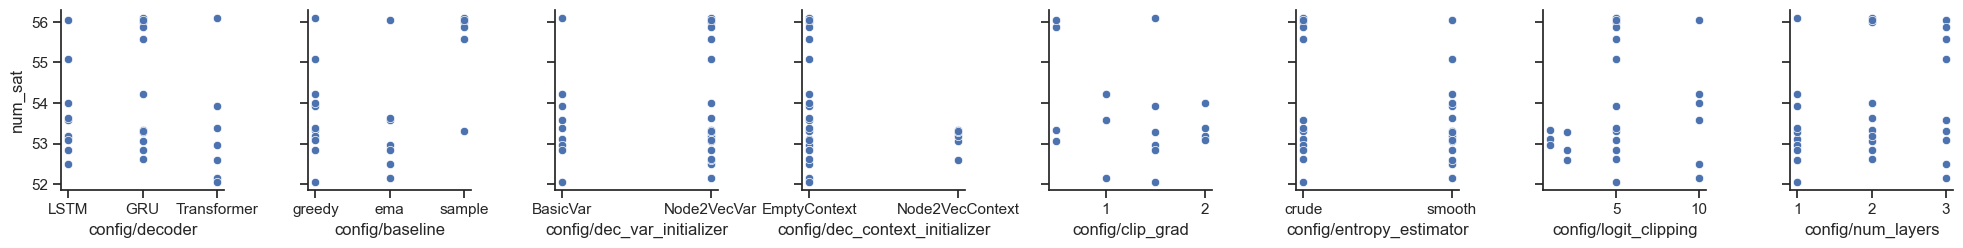

In [73]:


exp_path = 'hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=05'
print(f"\nLoading experiment results from: {exp_path}.")

restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver)

results = restored_tuner.get_results()

config = ['config/decoder', 'config/baseline', 'config/dec_var_initializer', 'config/dec_context_initializer',
                      'config/clip_grad', 'config/entropy_estimator', 'config/logit_clipping', 'config/num_layers']
df_hyper = results.get_dataframe(filter_metric="num_sat", filter_mode='max')[['num_sat'] + config]

#df_plot = pd.concat([df_pg, df_walksat], ignore_index=True)
sns.set_theme(style="ticks")
sns.pairplot(df_hyper, y_vars='num_sat', x_vars=config)

In [42]:
df_best5 = df_hyper.sort_values(by=['num_sat'], ascending=False).head(5)
df_best5

,num_sat,loss,num_sat_greedy_1,num_sat_sample_1_1,num_sat_sample_32_1,num_sat_sample_64_1,num_sat_sample_1_2,num_sat_sample_32_2,num_sat_sample_64_2,episode,...,config/n2v_p,config/n2v_pretrained,config/n2v_q,config/n2v_verbose,config/n2v_walk_len,config/n2v_walks_per_node,config/n2v_workers,config/dense_size,config/num_heads,config/k_samples
7,135.12500,-98.239009,134.0,137.0,140.0,142.0,130.0,139.0,141.0,260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,2.0,NaN
1,134.75000,-1.840298,134.0,135.0,138.0,138.0,134.0,139.0,139.0,330,...,0.25,True,2.0,0.0,20.0,10.0,0.0,NaN,NaN,NaN
13,134.62500,-19.571895,134.0,133.0,139.0,140.0,131.0,142.0,140.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,134.53125,-1273.013678,135.0,133.0,140.0,138.0,133.0,139.0,140.0,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.0,1.0,NaN
3,134.46875,-1.250642,134.0,132.0,138.0,138.0,132.0,141.0,138.0,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_config = df_best5[['num_sat', 'config/decoder', 'config/baseline', 'config/dec_var_initializer', 'config/dec_context_initializer',
                      'config/clip_grad', 'config/entropy_estimator', 'config/logit_clipping', 'config/num_layers']]
df_config

,num_sat,config/decoder,config/baseline,config/dec_var_initializer,config/dec_context_initializer,config/clip_grad,config/entropy_estimator,config/logit_clipping,config/num_layers
7,135.12500,Transformer,greedy,BasicVar,EmptyContext,0.5,smooth,5.0,2
1,134.75000,GRU,ema,Node2VecVar,Node2VecContext,NaN,crude,10.0,2
13,134.62500,LSTM,ema,BasicVar,EmptyContext,2.0,crude,5.0,2
24,134.53125,Transformer,None,BasicVar,EmptyContext,NaN,smooth,2.0,1
3,134.46875,LSTM,greedy,BasicVar,EmptyContext,2.0,crude,NaN,3


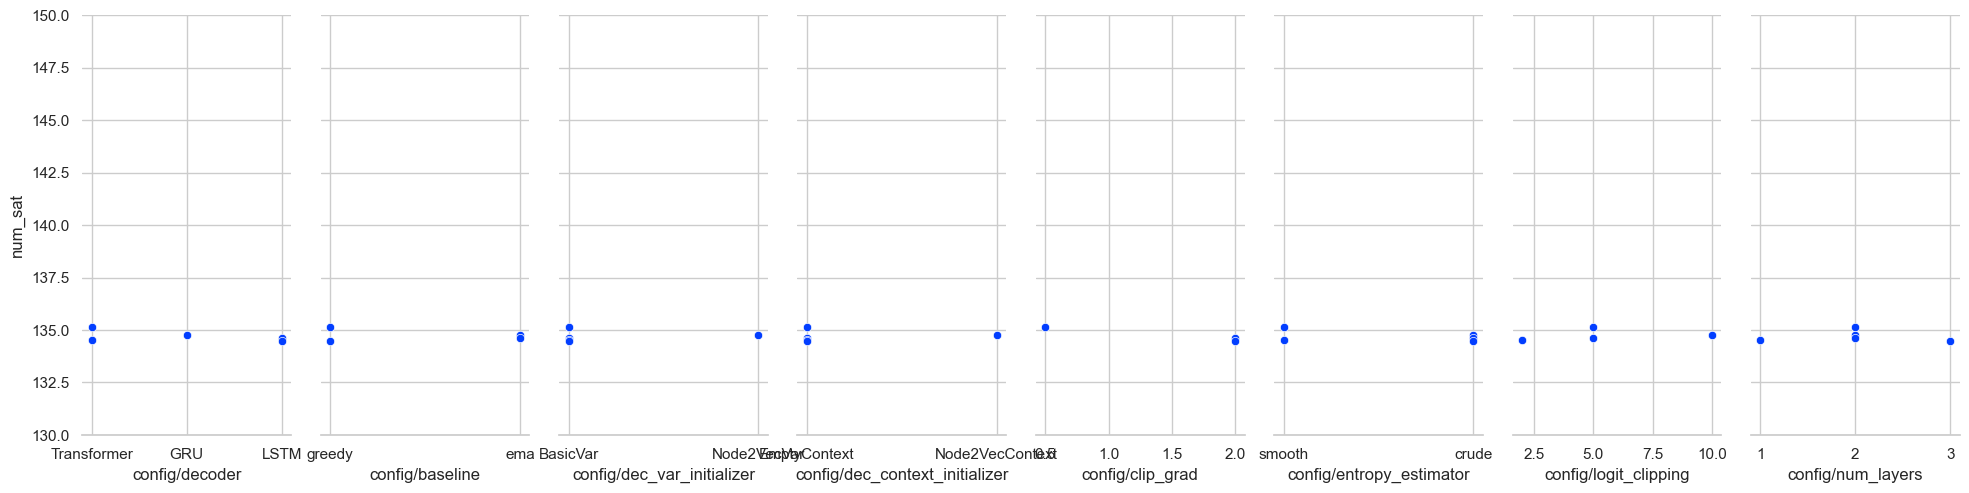

In [57]:
# Draw a categorical scatterplot to show each observation
config = ['config/decoder', 'config/baseline', 'config/dec_var_initializer', 'config/dec_context_initializer',
                      'config/clip_grad', 'config/entropy_estimator', 'config/logit_clipping', 'config/num_layers']

g = sns.PairGrid(data=df_config, y_vars='num_sat', x_vars=config, height=5, aspect=.5)

g.map(sns.scatterplot)
g.set(ylim=(130, 150))
sns.despine(fig=g.fig, left=True)

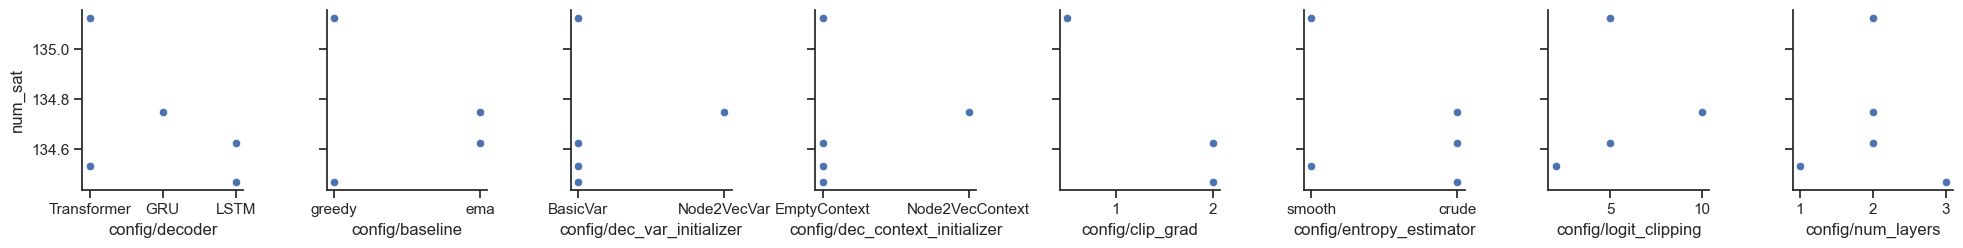

In [59]:
sns.set_theme(style="ticks")
sns.pairplot(df_config, y_vars='num_sat', x_vars=config)

In [18]:
df_hyper.columns

Index(['num_sat', 'loss', 'num_sat_greedy_1', 'num_sat_sample_1_1',
       'num_sat_sample_32_1', 'num_sat_sample_64_1', 'num_sat_sample_1_2',
       'num_sat_sample_32_2', 'num_sat_sample_64_2', 'episode', 'samples',
       'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'warmup_time',
       'config/accumulation_episodes', 'config/assignment_emb_size',
       'config/baseline', 'config/batch_size', 'config/beta_entropy',
       'config/checkpoint_dir', 'config/clip_grad', 'config/context_emb_size',
       'config/data_dir', 'config/dec_context_initializer',
       'config/dec_var_initializer', 'config/decoder', 'config/dropout',
       'config/entropy_estimator', 'config/eval_interval',
       'config/eval_strategies', 'config/exp_name', 'config/extra_log

In [ ]:
print(results.get_dataframe(filter_metric="num_sat", filter_mode='max')[f'{metric}'].max()")

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df_final, x="r", y="frac_sat", hue="search", errorbar=None, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [ ]:
best_config = best_result.config  # Get best trial's hyperparameters
best_logdir = best_result.log_dir  # Get best trial's logdir
best_checkpoint = best_result.checkpoint  # Get best trial's best checkpoint
best_metrics = best_result.metrics  # Get best trial's last results
best_result_df = best_result.metrics_dataframe  # Get best result as pandas dataframe

In [ ]:
num_vars = 50
exp_dir = 'hypersearch/pg_solver'
exp_path = os.path.join(exp_dir, f'{num_vars:04d}')

reader = SummaryReader(exp_path, pivot=False, extra_columns={'dir_name'})
df = reader.tensors
df

## Lab results experiment v1

In [ ]:
import src.utils as utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

In [ ]:
num_vars = 40
output_dir = 'outputs'
exp_name = os.path.join(output_dir, f'exp_{num_vars:04d}')

reader = SummaryReader(exp_name, pivot=False, extra_columns={'dir_name'})
df = reader.tensors
df

In [ ]:
# Keep only rows with tag == 'active_search'
df = df[df['tag'] == 'active_search']
df

In [ ]:
# Keep only step and value columns
df = df[['step', 'value', 'dir_name']]
df

In [ ]:
# Keep only the max num of sat clases reached
df = df.sort_values('value', ascending=True).drop_duplicates(['dir_name'], keep='last')
df

In [ ]:
# Split dir_name into m, config and run id
df_str = df.dir_name.str.split('/', expand=True).rename(columns={0:'m', 1:'config', 2: 'run_id' }).drop([3], axis=1)
df_str

In [ ]:
# Split run_id and get instance number
df_i = df_str.run_id.str.split('-', expand=True).rename(columns={1:'inst'}).drop([0,2], axis=1)
df_i

In [ ]:
# Del run_id from df_str
df_str = df_str.drop(['run_id'], axis=1)
df_str

In [ ]:
# Concat df_str and df_i
df_2 = pd.concat([df_str, df_i], axis=1)
df_2 

In [ ]:
# Concat df and df_2
df_results = pd.concat([df, df_2], axis=1)
df_results

In [ ]:
# Del dir_name and step column from df_results
df_results = df_results.drop(['dir_name', 'step'], axis=1)
df_results

In [ ]:
df_results['n'] = num_vars
df_results

In [ ]:
df_results['m'] = df_results['m'].astype(float)
df_results

In [ ]:
df_results.insert(5, 'r', df_results["m"] / df_results["n"])
df_results

In [ ]:
df_results.insert(6, 'frac_sat', df_results["value"] / df_results["m"])
df_results

In [ ]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")
sns.lineplot(data=df_results, x="r", y="frac_sat", hue="config", errorbar=('ci', 30), palette=color_pallete)
plt.tight_layout()
plt.show()

In [ ]:
from src.solvers import pg_solver
from ray import tune, air


# Load best resutls
exp_path = 'hypersearch/pg_solver/0020/0060/rand_n=0020_k=03_m=0060_i=01'
print(f"\nLoading best node2vec config from {exp_path} ...")

restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver)
results = restored_tuner.get_results()

best_result = results.get_best_result(metric='num_sat_greedy', mode="max")

best_config = best_result.config  # Get best trial's hyperparameters
best_logdir = best_result.log_dir  # Get best trial's logdir
best_checkpoint = best_result.checkpoint  # Get best trial's best checkpoint
best_metrics = best_result.metrics  # Get best trial's last results
best_result_df = best_result.metrics_dataframe  # Get best result as pandas dataframe

In [ ]:
import torch 
import os
state_dict = torch.load(os.path.join(logdir, "checkpoints/checkpoint.pt"))
state_dict